In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg

# Set random seed for reproducibility
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Hyperparameters
LEARNING_RATE = 5e-5
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64 
FEATURES_GEN = 64 
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

Using device: cuda


In [2]:
import os

# Load CIFAR-10 dataset
dataset = datasets.CIFAR10(
    root="./dataset/CIFAR10data", 
    download=True,
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Create results directory
if not os.path.exists('Results'):
    os.makedirs('Results')

Files already downloaded and verified


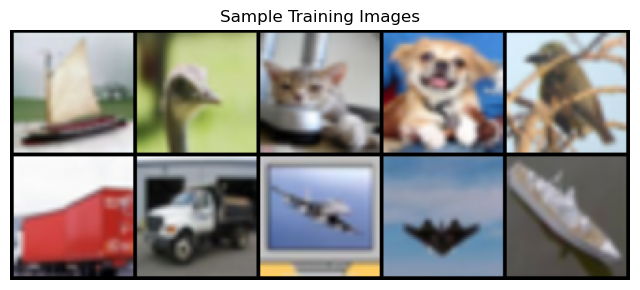

In [3]:
# Visualize a batch of real images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10], nrow=5, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.savefig('Results/WGANGP_RealImg.jpg', format='jpeg', dpi=100, bbox_inches='tight')

In [5]:
# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.create_block(features_d, features_d * 2, 4, 2, 1),
            self.create_block(features_d * 2, features_d * 4, 4, 2, 1),
            self.create_block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def create_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# Define the Generator model
class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels, features_g):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            self.create_layer(noise_channels, features_g * 8, 4, 1, 0),
            self.create_layer(features_g * 8, features_g * 4, 4, 2, 1),
            self.create_layer(features_g * 4, features_g * 2, 4, 2, 1),
            self.create_layer(features_g * 2, features_g, 4, 2, 1),
            nn.ConvTranspose2d(features_g, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def create_layer(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# Function to initialize weights
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [8]:
# Gradient Penalty function
def compute_gradient_penalty(critic, real, fake):
    batch_size, channels, height, width = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, channels, height, width).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)
    mixed_scores = critic(interpolated_images)
    gradients = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(gradients.shape[0], -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [9]:
# Create model directories
if not os.path.exists('Models'):
    os.makedirs('Models')

In [10]:
# Function to save models
def save_model(model, model_type):
    if model_type == 'generator':
        print("=> Saving Generator model!")
        torch.save(model.state_dict(), "Models/CIFAR_wganGP_GENERATOR.pth.tar")
    elif model_type == 'discriminator':
        print("=> Saving Discriminator model!")
        torch.save(model.state_dict(), "Models/CIFAR_wganGP_DIS.pth.tar")

In [11]:
# Function to load models
def load_model(generator, discriminator):
    print("=> Loading models!")
    generator.load_state_dict(torch.load("Models/CIFAR_wganGP_GENERATOR.pth.tar"))
    discriminator.load_state_dict(torch.load("Models/CIFAR_wganGP_DIS.pth.tar"))

In [12]:
# Initialize models
generator = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
discriminator = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(generator)
initialize_weights(discriminator)

In [13]:
# Optimizers
optimizer_gen = optim.RMSprop(generator.parameters(), lr=LEARNING_RATE)
optimizer_disc = optim.RMSprop(discriminator.parameters(), lr=LEARNING_RATE)

# Fixed noise for generating images
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
iteration = 0

In [14]:
# Set models to training mode
generator.train()
discriminator.train()


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [15]:
# InceptionV3 model for FID calculation
class InceptionV3(nn.Module):
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }

    def __init__(self, output_blocks=[DEFAULT_BLOCK_INDEX], resize_input=True, normalize_input=True, requires_grad=False):
        super(InceptionV3, self).__init__()
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, 'Last possible output block index is 3'

        self.blocks = nn.ModuleList()
        inception = models.inception_v3(pretrained=True)

        # Define blocks
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad  # Corrected line

    def forward(self, inp):
        outputs = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outputs.append(x)

            if idx == self.last_needed_block:
                break

        return outputs

In [16]:
# Get the block index for the Inception model
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx]).cuda()

/home/agolla/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/agolla/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# Function to calculate activation statistics
def compute_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    activations = np.empty((len(images), dims))

    if cuda:
        batch = images.cuda()
    else:
        batch = images

    predictions = model(batch)[0]
    if predictions.size(2) != 1 or predictions.size(3) != 1:
        predictions = F.adaptive_avg_pool2d(predictions, output_size=(1, 1))

    activations = predictions.cpu().data.numpy().reshape(predictions.size(0), -1)

    mean = np.mean(activations, axis=0)
    covariance = np.cov(activations, rowvar=False)
    return mean, covariance

In [18]:
# Function to calculate Frechet distance
def compute_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, 'Mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Covariance matrices have different dimensions'

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        print('Adding %s to diagonal of covariance estimates' % eps)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError('Imaginary component found in covariance matrix')
        covmean = covmean.real

    trace_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * trace_covmean)

In [19]:
# Function to calculate Frechet distance for real and fake images
def calculate_frechet(images_real, images_fake, model):
    mu_real, std_real = compute_activation_statistics(images_real, model, cuda=True)
    mu_fake, std_fake = compute_activation_statistics(images_fake, model, cuda=True)

    fid_value = compute_frechet_distance(mu_real, std_real, mu_fake, std_fake)
    return fid_value

In [ ]:
# Training loop
generator_loss = []
discriminator_loss = []
discriminator_loss_per_iteration = []
image_list = []
iterations = 0
fid_scores = []

print("Training has begun!")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch += 1
    
    for batch_index, data in enumerate(data_loader, 0):
        real_images = data[0].to(device)
        batch_size = real_images.shape[0]

        # Train Discriminator
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(batch_size, NOISE_DIM, 1, 1).to(device)
            fake_images = generator(noise)
            critic_real = discriminator(real_images).reshape(-1)
            critic_fake = discriminator(fake_images).reshape(-1)
            gradient_penalty = compute_gradient_penalty(discriminator, real_images, fake_images)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + (LAMBDA_GP * gradient_penalty)
            discriminator.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimizer_disc.step()

        # Train Generator
        output = discriminator(fake_images).reshape(-1)
        loss_gen = -torch.mean(output)
        generator.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

        # Store losses
        generator_loss.append(loss_gen.detach().cpu())
        discriminator_loss.append(loss_critic.detach().cpu())

        # Save generated images at intervals
        if (iterations % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_index == len(data_loader) - 1)):
            with torch.no_grad():
                fake_images = generator(fixed_noise).detach().cpu()
            image_list.append(utils.make_grid(fake_images, padding=2, normalize=True))

        iterations += 1

    # Calculate FID score
    fid_value = calculate_frechet(real_images, fake_images, inception_model)
    fid_scores.append(fid_value)
    print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_index}/{len(data_loader)} \
          Loss Discriminator: {loss_critic:.3f}, Loss Generator: {loss_gen:.3f}, FID Score: {fid_value:.3f}", end="\r", flush=True)

    # Save generated and real images
    if not os.path.exists('Results/WGANGP_FAKE'):
        os.makedirs('Results/WGANGP_FAKE')
    if not os.path.exists('Results/WGANGP_REAL'):
        os.makedirs('Results/WGANGP_REAL')

    utils.save_image(fake_images.detach(), f'Results/WGANGP_FAKE/WGANGP_epoch_{epoch:03d}.png', normalize=True)
    utils.save_image(real_images.detach(), f'Results/WGANGP_REAL/WGANGP_epoch_{epoch:03d}.png', normalize=True)

# Timing the training duration
end_time = time.time()
print(f'\n\nElapsed time: {end_time - start_time:.2f} seconds.')

Training has begun!


In [21]:
# Save loss data
if not os.path.exists('Results/Loss_Data'):
    os.makedirs('Results/Loss_Data')

np.save('Results/Loss_Data/WGANGP_GLoss', generator_loss)
np.save('Results/Loss_Data/WGANGP_DLoss', discriminator_loss)

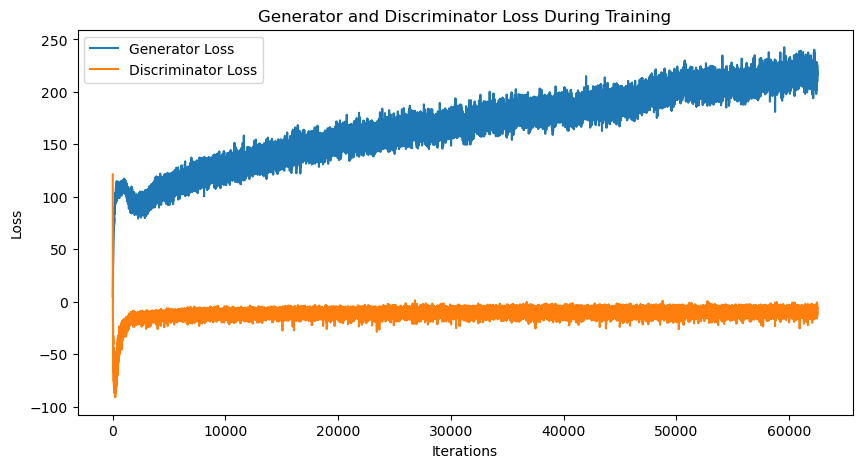

In [22]:
# Plotting losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss, label="Generator Loss")
plt.plot(discriminator_loss, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Results/Loss.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()

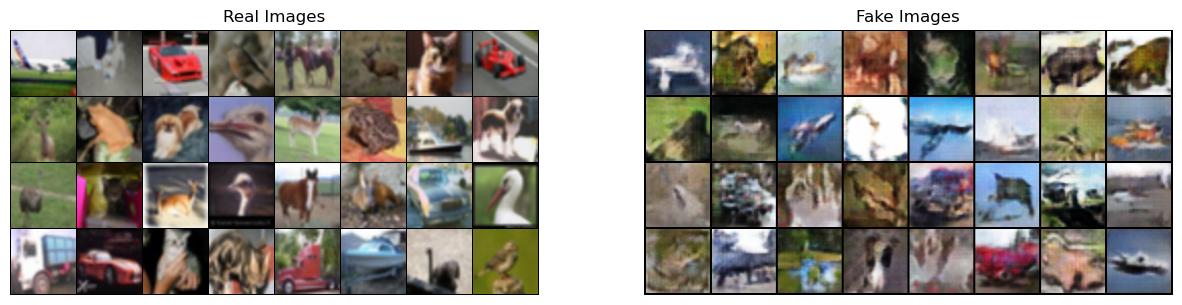

In [23]:
# Visualize real and fake images
real_batch = next(iter(data_loader))
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(), (1, 2, 0)))
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(image_list[-1], (1, 2, 0)))
plt.savefig('Results/WGANGP_BEST_FAKE_32.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()

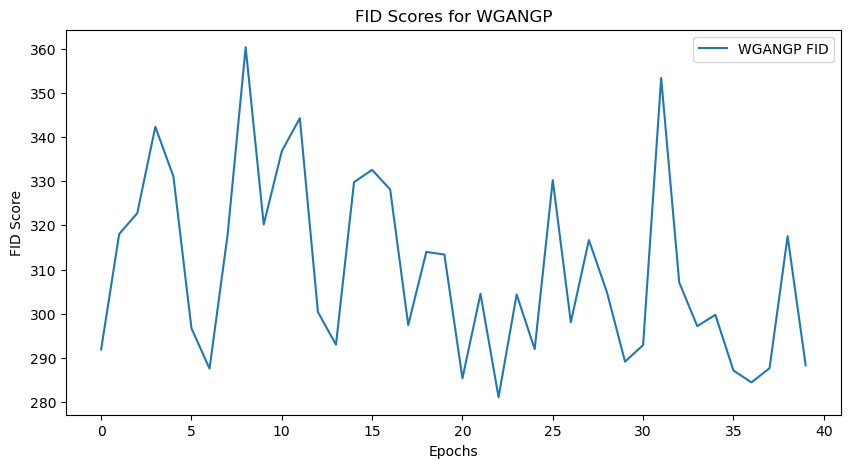

In [24]:
# Plot FID scores
plt.figure(figsize=(10, 5))
plt.title("FID Scores for WGANGP")
plt.plot(fid_scores, label="WGANGP FID")
plt.xlabel("Epochs")
plt.ylabel("FID Score")
plt.legend()
plt.savefig('Results/FID.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [26]:
# Save FID scores
if not os.path.exists('Results/FID_score'):
    os.makedirs('Results/FID_score')
np.save('Results/FID_score/WGANGP_FID', fid_scores)